In [1]:
%pip install geopandas shapely pyproj folium
%pip install cdsapi
%pip install -U ecmwf-datastores-client
import sys
import subprocess

# Install netCDF4 if not already installed
subprocess.check_call([sys.executable, "-m", "pip", "install", "netCDF4"])


# Libraries
import os
from ecmwf.datastores import Client
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!jupyter trust "download_daily_temp_era5.ipynb.ipynb"


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-trust` not found.


In [3]:
import geopandas as gpd

# Load shapefile
shp_path = "/Users/elindner/Documents/Climatematch/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path)

# Ensure projection is lat/lon (WGS84)
gdf = gdf.to_crs(epsg=4326)

# Get bounding box
minx, miny, maxx, maxy = gdf.total_bounds

# ERA5 format: [North, West, South, East]
bbox = [maxy, minx, miny, maxx]

print("ERA5 bbox:", bbox)


ERA5 bbox: [np.float64(12.500951000000157), np.float64(-1.6843399999999065), np.float64(12.259243999999967), np.float64(-1.4119559999999183)]


In [4]:
# convert to float
bbox = [float(x) for x in bbox]
print("ERA5 bbox (clean):", bbox)


ERA5 bbox (clean): [12.500951000000157, -1.6843399999999065, 12.259243999999967, -1.4119559999999183]


In [5]:
# display box on map to double-check - image saved to folder
import folium
from shapely.geometry import box
import geopandas as gpd


# Keep only geometry to avoid Timestamp serialization errors
gdf_geom = gdf[["geometry"]]

# Use existing bbox variable
north, west, south, east = bbox
bbox_polygon = box(west, south, east, north)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

# Center map on bbox
map_center = [(north + south)/2, (west + east)/2]
m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")

# Add city boundary (blue)
folium.GeoJson(
    gdf_geom,
    name="Ouagadougou Boundary",
    style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0}
).add_to(m)

# Add ERA5 bbox (red)
folium.GeoJson(
    bbox_gdf,
    name="ERA5 bbox",
    style_function=lambda x: {"color": "red", "weight": 2, "fillOpacity": 0.3}
).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Display map
m
m.save("ouagadougou_bbox_map.html")
print("Map saved as ouagadougou_bbox_map.html. Open this file in your browser to view it.")



Map saved as ouagadougou_bbox_map.html. Open this file in your browser to view it.


In [6]:
import os
os.environ['CDSAPI_RC'] = '/Users/elindner/Documents/Climatematch/Heatwave/Copernicus.cdsapirc'
import cdsapi
client = cdsapi.Client()
print("CDS client initialized successfully")


CDS client initialized successfully


In [7]:
import cdsapi
import os

# === CONFIG ===
DATADIR = "/Users/elindner/Documents/Climatematch/Heatwave/"
os.makedirs(DATADIR, exist_ok=True)

# Point cdsapi to your key file
os.environ['CDSAPI_RC'] = '/Users/elindner/Documents/Climatematch/Heatwave/Copernicus.cdsapirc'

client = cdsapi.Client()
print("CDS client initialized successfully")

# === REFINED BBOX ===
# North, West, South, East
bbox = [12.5, -1.7, 12.3, -1.4]
print("Using bounding box:", bbox)

# === DOWNLOAD ONE YEAR ===
annee = '2024'
output_file = os.path.join(DATADIR, f"Era5_land_{annee}_Ouagadougou_daily_test.zip")

if os.path.exists(output_file):
    print(f"Already exists: {output_file}")
else:
    try:
        request = {
            "variable": ["2m_temperature"],
            "year": annee,
            "month": [f"{i:02d}" for i in range(1, 13)],
            "day": [f"{i:02d}" for i in range(1, 32)],
            "daily_statistic": "daily_maximum",
            "time_zone": "utc+00:00",
            "frequency": "1_hourly",
            "area": bbox
        }

        client.retrieve("derived-era5-land-daily-statistics", request).download(output_file)
        print(f"Downloaded: {output_file}")

    except Exception as e:
        print(f"Failed {annee}: {e}")


CDS client initialized successfully
Using bounding box: [12.5, -1.7, 12.3, -1.4]
Already exists: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2024_Ouagadougou_daily_test.zip


In [8]:
import xarray as xr

ds = xr.open_dataset("Era5_land_2024_Ouagadougou_daily_test.zip")  # or rename .zip to .nc
print(ds.latitude.values)
print(ds.longitude.values)


[12.5 12.4 12.3]
[-1.7 -1.6 -1.5 -1.4]


Grid latitudes: [12.5 12.4 12.3]
Grid longitudes: [-1.7 -1.6 -1.5 -1.4]
Inferred resolution: 0.100°


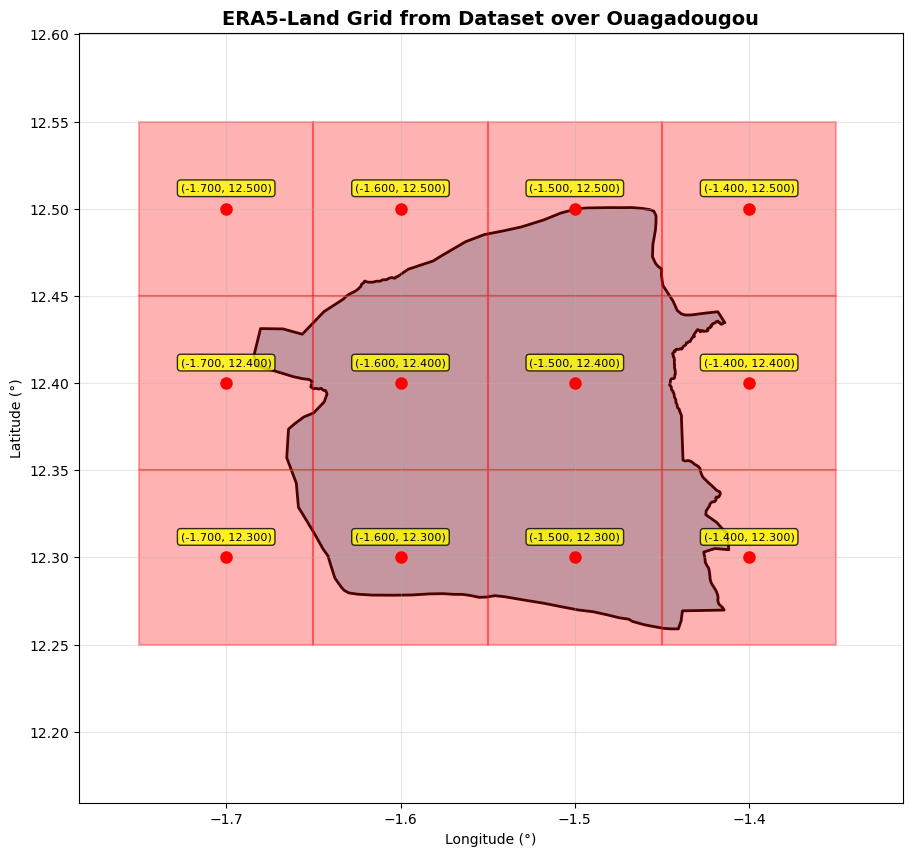

In [9]:


import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# === Load ERA5 dataset ===
FILE = "/Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2024_Ouagadougou_daily_test.zip"
ds = xr.open_dataset(FILE)

# === Load Ouagadougou shapefile ===
shp_path = "/Users/elindner/Documents/Climatematch/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

# === Detect coordinate names ===
lat_name = [v for v in ds.coords if "lat" in v.lower()][0]
lon_name = [v for v in ds.coords if "lon" in v.lower()][0]

lats = ds[lat_name].values
lons = ds[lon_name].values

print("Grid latitudes:", lats)
print("Grid longitudes:", lons)

# === Infer grid resolution ===
grid_res_lat = np.abs(np.diff(lats)).mean()
grid_res_lon = np.abs(np.diff(lons)).mean()
grid_res = (grid_res_lat + grid_res_lon) / 2

print(f"Inferred resolution: {grid_res:.3f}°")

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 10))

# Plot shapefile
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=2)

# Plot grid cells from dataset
for lat in lats:
    for lon in lons:
        rect = Rectangle(
            (lon - grid_res/2, lat - grid_res/2),
            grid_res, grid_res,
            linewidth=1.5, edgecolor='red',
            facecolor='red', alpha=0.3
        )
        ax.add_patch(rect)
        
        # Center point
        ax.plot(lon, lat, 'ro', markersize=8)

        # Label
        ax.text(lon, lat + 0.01, f"({lon:.3f}, {lat:.3f})",
                fontsize=8, ha='center',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Zoom to shape area
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.1, maxx + 0.1)
ax.set_ylim(miny - 0.1, maxy + 0.1)

# Layout
ax.set_aspect("equal")
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("ERA5-Land Grid from Dataset over Ouagadougou", fontsize=14, weight="bold")

plt.grid(alpha=0.3)
plt.show()



Shapefile bounds: lon [-1.6843, -1.4120], lat [12.2592, 12.5010]

Total grid cells that intersect shapefile: 11

Intersecting latitudes: [np.float64(12.3), np.float64(12.4), np.float64(12.5)]
Intersecting longitudes: [np.float64(-1.7000000000000002), np.float64(-1.6), np.float64(-1.5), np.float64(-1.4)]

Optimal ERA5-Land bounding box [N, W, S, E]: [np.float64(12.5), np.float64(-1.7000000000000002), np.float64(12.3), np.float64(-1.4)]


/var/folders/zh/vv_ph5h91yzf_q6cpgm75d1c0000gn/T/ipykernel_904/888168259.py:31: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapefile_union = gdf.unary_union


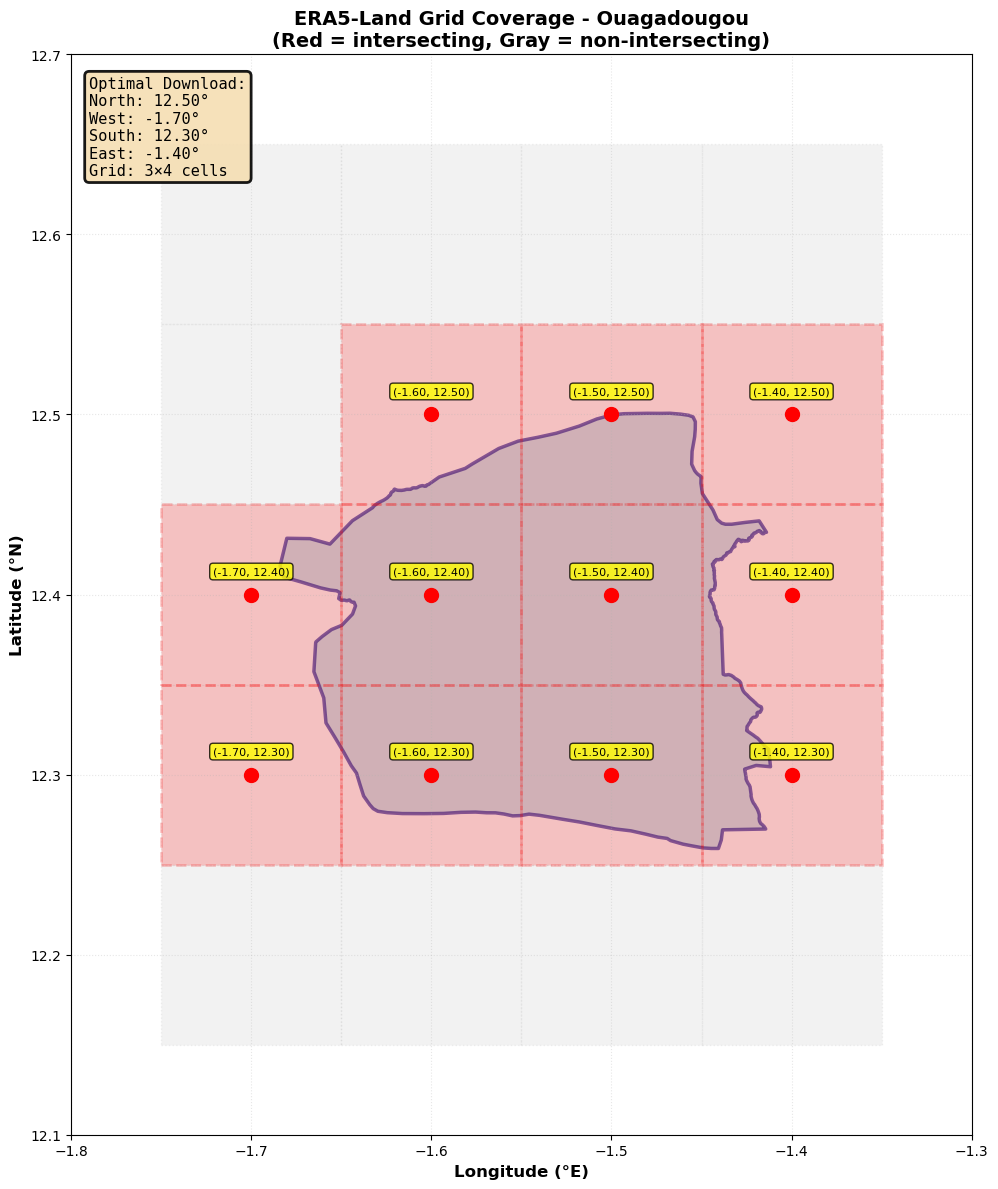


OPTIMAL DOWNLOAD COORDINATES
North: 12.5
West: -1.7000000000000002
South: 12.3
East: -1.4


In [11]:
import cdsapi
import os

# === CONFIG ===
DATADIR = "/Users/elindner/Documents/Climatematch/Heatwave/"
os.makedirs(DATADIR, exist_ok=True)

# Point cdsapi to your key file
os.environ['CDSAPI_RC'] = '/Users/elindner/Documents/Climatematch/Heatwave/Copernicus.cdsapirc'

client = cdsapi.Client()
print("CDS client initialized successfully")
bbox = [12.5, -1.7, 12.3, -1.4]
print("Using bounding box:", bbox)  # use the previously defined bbox variable

# === YEARS ===
baseline_years = list(map(str, range(2001, 2021)))  # 1991–2020
target_year = ['2024']                               # target year
Annees = baseline_years + target_year

# === DOWNLOAD LOOP: one file per year ===
for annee in Annees:

    output_file = f"{DATADIR}Era5_land_{annee}_Ouagadougou_daily.zip"

    if os.path.exists(output_file):
        print(f"Already exists: {output_file}")
        continue

    try:
        request = {
            "variable": ["2m_temperature"],
            "year": annee,
            "month": [f"{i:02d}" for i in range(1, 13)],  # all months
            "day": [f"{i:02d}" for i in range(1, 32)],     # all possible days
            "daily_statistic": "daily_maximum",
            "time_zone": "utc+00:00",
            "frequency": "1_hourly",
            "area": bbox  # use the existing bbox variable
        }

        client.retrieve("derived-era5-land-daily-statistics", request).download(output_file)
        print(f"Downloaded: {output_file}")

    except Exception as e:
        print(f"Failed {annee}: {e}")



CDS client initialized successfully
Using bounding box: [12.5, -1.7, 12.3, -1.4]
Already exists: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2001_Ouagadougou_daily.zip
Already exists: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2002_Ouagadougou_daily.zip


2025-12-02 17:36:16,929 INFO Request ID is 1d34505e-78f0-4348-bfea-64b2afc1c439
2025-12-02 17:36:17,002 INFO status has been updated to accepted
2025-12-02 19:18:50,308 INFO status has been updated to running
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-12-02 19:37:23,688 INFO status has been updated to successful


2203d4cf76177513bdef25536462586b.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2003_Ouagadougou_daily.zip


2025-12-02 19:37:24,745 INFO Request ID is 347b478b-0459-482e-8f79-ec49a22516b4
2025-12-02 19:37:24,844 INFO status has been updated to accepted
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
2025-12-02 22:20:45,966 INFO status has been updated to running
2025-12-02 22:38:48,723 INFO status has been updated to successful


9baad8aa2de3c44b87a169b0f07ae03c.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2004_Ouagadougou_daily.zip


2025-12-02 22:38:50,650 INFO Request ID is 33e23ddd-0172-42b2-be85-959805f10411
2025-12-02 22:38:50,766 INFO status has been updated to accepted
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
2025-12-03 00:50:09,764 INFO status has been updated to running
2025-12-03 01:08:12,038 INFO status has been updated to successful


8fea4794b8c6f0b0d46add0048dda902.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

2025-12-03 01:08:12,949 INFO Request ID is 25a0e977-3654-4019-a3e8-770204703958


Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2005_Ouagadougou_daily.zip


2025-12-03 01:08:13,024 INFO status has been updated to accepted
2025-12-03 02:52:44,450 INFO status has been updated to running
2025-12-03 03:10:47,104 INFO status has been updated to successful


5505d87ae72a9102b586a32fe12a4322.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

2025-12-03 03:10:47,869 INFO Request ID is 70345ee3-1c93-43cb-bf47-e61b750b31b7


Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2006_Ouagadougou_daily.zip


2025-12-03 03:10:47,942 INFO status has been updated to accepted
2025-12-03 04:49:20,374 INFO status has been updated to running
2025-12-03 05:11:23,412 INFO status has been updated to successful


b87e78d540b78ad782c706abbe16cf8d.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2007_Ouagadougou_daily.zip


2025-12-03 05:11:24,530 INFO Request ID is 6b8ed797-bffc-4c21-90bc-3157e4f250d0
2025-12-03 05:11:24,608 INFO status has been updated to accepted
2025-12-03 07:52:05,690 INFO status has been updated to running
2025-12-03 08:14:09,327 INFO status has been updated to successful


3fb390fad73011de8cf37ba7a654b9eb.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2008_Ouagadougou_daily.zip


2025-12-03 08:14:10,420 INFO Request ID is 3f908e00-49d4-4673-8868-6aff7be3e287
2025-12-03 08:14:10,500 INFO status has been updated to accepted
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
2025-12-03 09:53:47,574 INFO status has been updated to running
2025-12-03 10:13:52,389 INFO status has been updated to successful


70857ede04e4ef8afc3b8b197200884c.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2009_Ouagadougou_daily.zip


2025-12-03 10:13:53,784 INFO Request ID is a82518a2-eae5-4df9-80ff-397b887e6f77
2025-12-03 10:13:53,896 INFO status has been updated to accepted
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attempt 1 of 500
Retrying in 120 seconds
2025-12-03 12:53:53,657 INFO status has been updated to running
2025-12-03 13:13:58,039 INFO status has been updated to successful


9bbc70ac4a791c2a66e5b44d481ab9e8.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2010_Ouagadougou_daily.zip


2025-12-03 13:13:59,422 INFO Request ID is bece6656-0617-4560-bf0b-632e99101352
2025-12-03 13:13:59,610 INFO status has been updated to accepted
2025-12-03 16:10:49,738 INFO status has been updated to running
2025-12-03 16:30:53,707 INFO status has been updated to successful


d98d00eb1ded08fad3706748c0fa5e1c.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2011_Ouagadougou_daily.zip


2025-12-03 16:30:54,826 INFO Request ID is f5464fb4-003b-475b-829a-0d300b2fb3a6
2025-12-03 16:30:54,909 INFO status has been updated to accepted
2025-12-03 19:37:48,477 INFO status has been updated to running
2025-12-03 19:55:51,988 INFO status has been updated to successful


e042b8a2f466ab1767052a94e6aa3901.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2012_Ouagadougou_daily.zip


2025-12-03 19:55:53,694 INFO Request ID is 94dc9ae1-8578-4e0c-b221-2e394acc26b7
2025-12-03 19:55:53,777 INFO status has been updated to accepted
2025-12-03 22:00:42,111 INFO status has been updated to running
2025-12-03 22:18:45,187 INFO status has been updated to successful


41f8b0e24dc92a88a827d783cbba2569.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2013_Ouagadougou_daily.zip


2025-12-03 22:18:46,427 INFO Request ID is 9fb76005-4f4c-430c-9c5b-ef0f660e3d3f
2025-12-03 22:18:46,537 INFO status has been updated to accepted
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/9fb76005-4f4c-430c-9c5b-ef0f660e3d3f?log=True&request=True (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x332209710>: Failed to resolve 'cds.climate.copernicus.eu' ([Errno 8] nodename nor servname provided, or not known)"))], attempt 1 of 500
Retrying in 120 seconds
2025-12-04 00:17:58,404 INFO status has been updated to running
2025-12-04 00:38:03,173 INFO status has been updated to successful


948eb0b3cd822f001d435d1c576be06c.nc:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2014_Ouagadougou_daily.zip


2025-12-04 00:38:04,351 INFO Request ID is f0468437-b18b-4ab2-b065-c353280b5ab9
2025-12-04 00:38:04,432 INFO status has been updated to accepted
2025-12-04 02:32:50,768 INFO status has been updated to running
2025-12-04 02:50:55,061 INFO status has been updated to successful


ac3a99ae4b1e3630a70716a428ac9ebe.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2015_Ouagadougou_daily.zip


2025-12-04 02:50:56,573 INFO Request ID is 8c78f4cd-e56a-4baf-bec2-98409cd66b04
2025-12-04 02:50:56,684 INFO status has been updated to accepted
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
2025-12-04 04:16:19,054 INFO status has been updated to running
2025-12-04 04:36:24,126 INFO status has been updated to successful


7336472ef6e44c910d40d6ff19fc256b.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2016_Ouagadougou_daily.zip


2025-12-04 04:36:25,726 INFO Request ID is be77a6bd-d115-42d0-9241-46b78f4d72f9
2025-12-04 04:36:25,833 INFO status has been updated to accepted
2025-12-04 06:01:04,952 INFO status has been updated to running
2025-12-04 06:19:10,085 INFO status has been updated to successful


cf896dd79d2fea126e87231a4433549e.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2017_Ouagadougou_daily.zip


2025-12-04 06:19:11,697 INFO Request ID is 459b5601-8895-4160-9132-9670e19ccb44
2025-12-04 06:19:11,851 INFO status has been updated to accepted
2025-12-04 07:55:53,349 INFO status has been updated to running
2025-12-04 08:11:57,034 INFO status has been updated to successful


dabf537f2ef1400b5b356ba2d6fcf28d.nc:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2018_Ouagadougou_daily.zip


2025-12-04 08:11:58,208 INFO Request ID is 987e0caa-203c-4266-8a4e-374f09cdcfb1
2025-12-04 08:11:58,290 INFO status has been updated to accepted
2025-12-04 09:46:33,260 INFO status has been updated to running
2025-12-04 10:06:36,107 INFO status has been updated to successful


bf22c23eeb34c98d5d4415972dd931bb.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2019_Ouagadougou_daily.zip


2025-12-04 10:06:37,085 INFO Request ID is ce391c2e-6f3e-47a5-ab22-a0bd0499788d
2025-12-04 10:06:37,173 INFO status has been updated to accepted
2025-12-04 11:39:12,088 INFO status has been updated to running
2025-12-04 11:55:14,617 INFO status has been updated to successful


134acd754efd6bbde20227ab498e028c.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2020_Ouagadougou_daily.zip


2025-12-04 11:55:15,612 INFO Request ID is 564e01b7-671d-4fef-a35f-bd81b129e61d
2025-12-04 11:55:15,709 INFO status has been updated to accepted
2025-12-04 13:49:53,724 INFO status has been updated to successful


58f3c3b05cb55125b335934d44c07b65.nc:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

Downloaded: /Users/elindner/Documents/Climatematch/Heatwave/Era5_land_2024_Ouagadougou_daily.zip



import sys
import subprocess
import importlib

# Function to install a package if it's missing
def install_if_missing(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Ensure netCDF4 is installed
install_if_missing("netCDF4")

import xarray as xr
import glob
import os

In [1]:
#changed from zip to nc in terminal before as there was some issue with the zip ending
# % cd /Users/elindner/Documents/Climatematch/Heatwave
# Heatwave % for f in *.zip; do mv "$f" "${f%.zip}.nc"; done

import xarray as xr
import glob
import os

data_dir = "/Users/elindner/Documents/Climatematch/Heatwave"
output_file = os.path.join(data_dir, "Ouagadougou_1991_2024_daily.nc")

# Get all .nc files
files = sorted(glob.glob(os.path.join(data_dir, "Era5_land_*_Ouagadougou_daily.nc")))
print("Files found:", len(files))

# Open each file individually and concatenate
datasets = [xr.open_dataset(f) for f in files]
ds = xr.concat(datasets, dim='time')

# Save merged dataset
ds.to_netcdf(output_file)
print("✅ Merged dataset written:", output_file)




Files found: 31


/var/folders/zh/vv_ph5h91yzf_q6cpgm75d1c0000gn/T/ipykernel_1055/2062833068.py:18: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'valid_time' ('valid_time',) The recommendation is to set join explicitly for this case.
  ds = xr.concat(datasets, dim='time')


✅ Merged dataset written: /Users/elindner/Documents/Climatematch/Heatwave/Ouagadougou_1991_2024_daily.nc


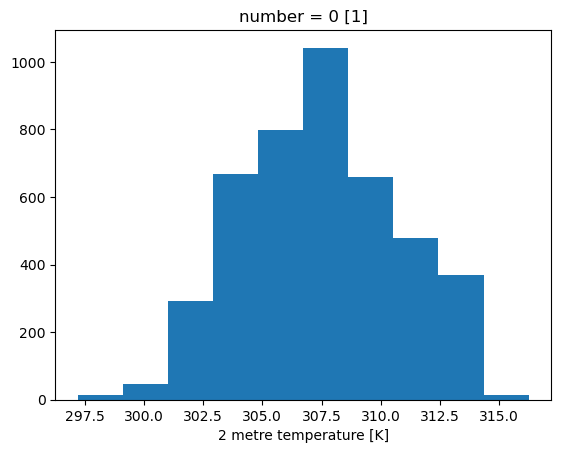

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

# Open merged dataset
data = xr.open_dataset('/Users/elindner/Documents/Climatematch/Heatwave/Ouagadougou_1991_2024_daily.nc')

# Plot first day
data["t2m"][0,:,:].plot()  # "t2m" might be "2m_temperature" depending on the variable name
plt.show()


<xarray.Dataset> Size: 17MB
Dimensions:     (time: 31, valid_time: 11324, latitude: 3, longitude: 4)
Coordinates:
  * latitude    (latitude) float64 24B 12.5 12.4 12.3
  * longitude   (longitude) float64 32B -1.7 -1.6 -1.5 -1.4
  * valid_time  (valid_time) datetime64[ns] 91kB 1991-01-01 ... 2024-12-31
    number      int64 8B ...
Dimensions without coordinates: time
Data variables:
    t2m         (time, valid_time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-01T17:25 GRIB to CDM+CF via cfgrib-0.9.1...


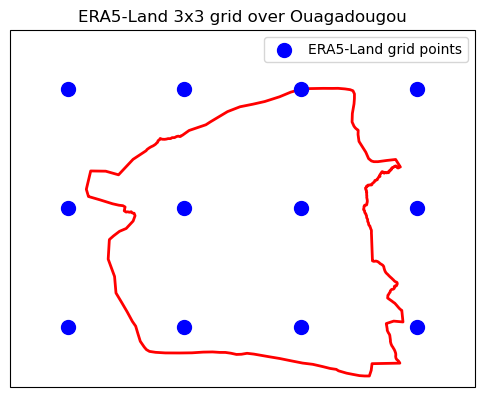

In [6]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load ERA5-Land dataset
ds = xr.open_dataset('/Users/elindner/Documents/Climatematch/Heatwave/Ouagadougou_1991_2024_daily.nc')
print(ds)

# Load Ouagadougou shapefile
shp_path = "/Users/elindner/Documents/Climatematch/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path)
gdf = gdf.to_crs(epsg=4326)  # Ensure lat/lon

# Get grid cell centers from ERA5-Land
lons = ds.longitude.values
lats = ds.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min()-0.05, lons.max()+0.05, lats.min()-0.05, lats.max()+0.05])

# Plot Ouagadougou boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot ERA5-Land 3x3 grid points
ax.scatter(lon2d, lat2d, color='blue', s=100, label='ERA5-Land grid points')

# Title and legend
ax.set_title("ERA5-Land 3x3 grid over Ouagadougou")
plt.legend()
plt.show()


In [4]:



# Get bounding box of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds
print("Ouagadougou shapefile bounds:")
print(f"min longitude: {minx}, max longitude: {maxx}")
print(f"min latitude: {miny}, max latitude: {maxy}\n")

# Get ERA5-Land grid coordinates
lons = ds.longitude.values
lats = ds.latitude.values
print("ERA5-Land grid coordinates:")
print("Longitudes:", lons)
print("Latitudes:", lats, "\n")

# Optional: find which grid points fall inside the shapefile bounds
mask_lon = (lons >= minx) & (lons <= maxx)
mask_lat = (lats >= miny) & (lats <= maxy)
selected_lons = lons[mask_lon]
selected_lats = lats[mask_lat]

print("ERA5-Land grid points inside Ouagadougou bounding box:")
print("Longitudes:", selected_lons)
print("Latitudes:", selected_lats)


Ouagadougou shapefile bounds:
min longitude: -1.6843399999999065, max longitude: -1.4119559999999183
min latitude: 12.259243999999967, max latitude: 12.500951000000157

ERA5-Land grid coordinates:
Longitudes: [-1.7 -1.6 -1.5 -1.4]
Latitudes: [12.5 12.4 12.3] 

ERA5-Land grid points inside Ouagadougou bounding box:
Longitudes: [-1.6 -1.5]
Latitudes: [12.5 12.4 12.3]


ERA5 latitudes: [12.5 12.4 12.3]
ERA5 longitudes: [-1.7 -1.6 -1.5 -1.4]
Shapefile bounds: lon [-1.6843, -1.4120], lat [12.2592, 12.5010]
ERA5 grid resolution: 0.09999999999999964


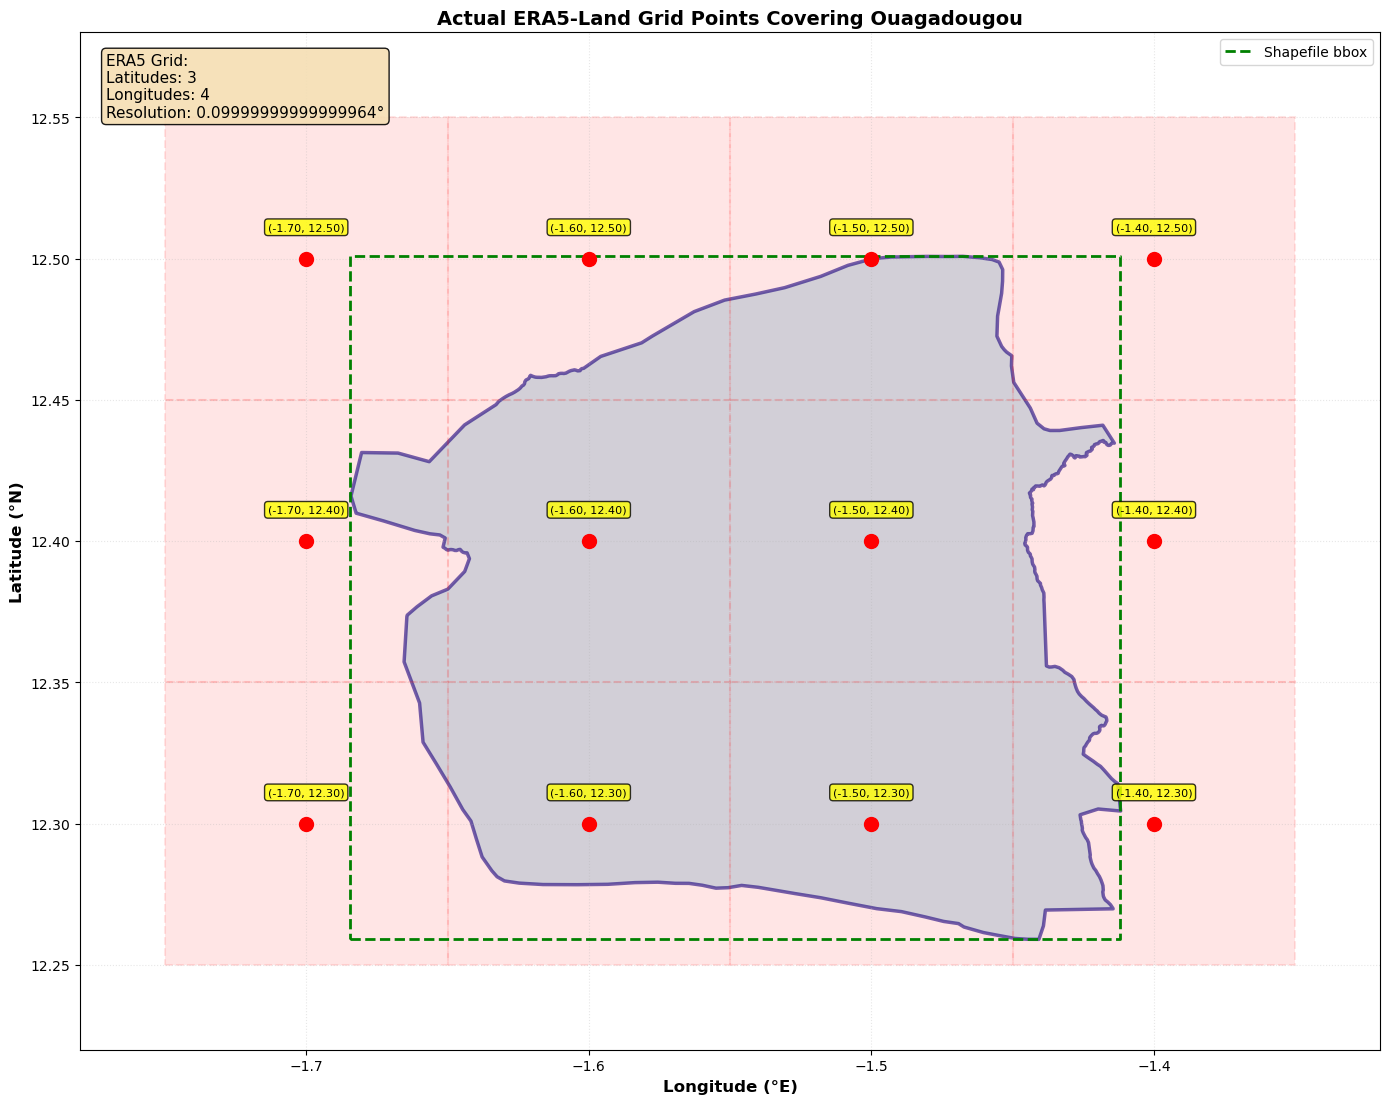

In [13]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xarray as xr

# === Load ERA5 dataset ===
ds = xr.open_dataset("/Users/elindner/Documents/Climatematch/Heatwave/Ouagadougou_1991_2024_daily.nc")

era_lats = ds.latitude.values
era_lons = ds.longitude.values

print("ERA5 latitudes:", era_lats)
print("ERA5 longitudes:", era_lons)

# === Load shapefile ===
shp_path = "/Users/elindner/Documents/Climatematch/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

# === Extract shapefile bounds ===
minx, miny, maxx, maxy = gdf.total_bounds
print(f"Shapefile bounds: lon [{minx:.4f}, {maxx:.4f}], lat [{miny:.4f}, {maxy:.4f}]")

# === ERA5 grid resolution (from the dataset) ===
grid_res = float(np.abs(era_lats[1] - era_lats[0]))
print("ERA5 grid resolution:", grid_res)

selected_lats = era_lats
selected_lons = era_lons

# === Create Visualization ===
fig, ax = plt.subplots(figsize=(14, 12))

# Plot shapefile
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='darkblue',
         linewidth=2.5, alpha=0.6)

# Plot each ERA5 grid cell
for lat in selected_lats:
    for lon in selected_lons:
        rect = Rectangle(
            (lon - grid_res/2, lat - grid_res/2),
            grid_res, grid_res,
            linewidth=1.5, edgecolor='red',
            facecolor='red', alpha=0.1, linestyle='--'
        )
        ax.add_patch(rect)
        ax.plot(lon, lat, 'ro', markersize=10, zorder=5)

# Add coordinate labels
for lat in selected_lats:
    for lon in selected_lons:
        ax.text(lon, lat + 0.01, f"({lon:.2f}, {lat:.2f})",
                fontsize=8, ha='center',
                bbox=dict(boxstyle='round,pad=0.3',
                          facecolor='yellow', alpha=0.8))

# Draw shapefile bounding box (green dashed)
ax.plot([minx, maxx, maxx, minx, minx],
        [miny, miny, maxy, maxy, miny],
        'g--', linewidth=2, label="Shapefile bbox")

# Plot formatting
padding = 0.08
ax.set_xlim(min(selected_lons) - padding, max(selected_lons) + padding)
ax.set_ylim(min(selected_lats) - padding, max(selected_lats) + padding)

ax.set_xlabel("Longitude (°E)", fontsize=12, fontweight="bold")
ax.set_ylabel("Latitude (°N)", fontsize=12, fontweight="bold")
ax.set_title("Actual ERA5-Land Grid Points Covering Ouagadougou", fontsize=14, fontweight="bold")

ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(loc="upper right", fontsize=10)
ax.set_aspect("equal")

# Add text box
textstr = f"ERA5 Grid:\nLatitudes: {len(selected_lats)}\nLongitudes: {len(selected_lons)}\nResolution: {grid_res}°"
ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
        fontsize=11, va='top',
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.9))

plt.tight_layout()
plt.show()


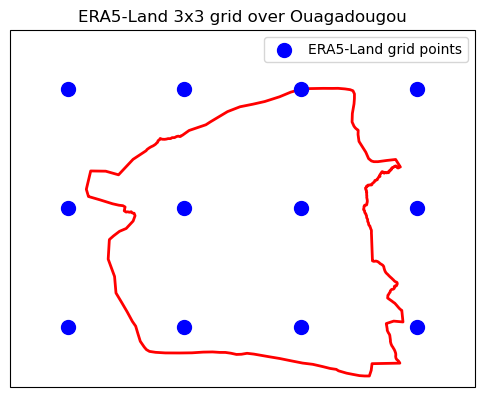

In [14]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load ERA5-Land dataset
ds = xr.open_dataset('/Users/elindner/Documents/Climatematch/Heatwave/Ouagadougou_1991_2024_daily.nc')

# Load Ouagadougou shapefile
shp_path = "/Users/elindner/Documents/Climatematch/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path)
gdf = gdf.to_crs(epsg=4326)  # Ensure lat/lon

# Get grid cell centers from ERA5-Land
lons = ds.longitude.values
lats = ds.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min()-0.05, lons.max()+0.05, lats.min()-0.05, lats.max()+0.05])

# Plot Ouagadougou boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot ERA5-Land 3x3 grid points
ax.scatter(lon2d, lat2d, color='blue', s=100, label='ERA5-Land grid points')

# Title and legend
ax.set_title("ERA5-Land 3x3 grid over Ouagadougou")
plt.legend()
plt.show()
